# A comedy handbook - preliminary results and analysis

In this notebook, you will find the preliminary results and code needed for Milestone 2 of the project. This same notebook will be updated for milestone 3 as the project progresses.

The goal of this notebook is to showcase the feasability of the approaches mentionned in our report. It also contains a presentation of the various datasets we use, as well as the initial data cleaning and pre-processing done on them. 

## Imports, constants and data loading

In [518]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [519]:
import pandas as pd
import swifter # Looks unused but actually is through Monkey Patching -- don't delete
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from src.utils.data_utils import *
from src.utils.general_utils import *
from tqdm import tqdm
from prettytable import PrettyTable
from ipywidgets import interact

pd.options.mode.copy_on_write = True

In [520]:
# Constants

TEXT_SEPARATOR = "_" * 40
# The following Color Palette is color-blind friendly, as has been carefully curated from Tol and IBM's specialized palettes (https://davidmathlogic.com/colorblind/)
# You can play with it/visualize it here : https://coolors.co/332288-88ccee-e69f00-44aa99-f0e442-d55e00-882255-009e73 
COLOR_PALETTE = ["#332288","#88ccee","#e69f00","#44aa99","#f0e442","#d55e00","#882255","#009e73"]

RES_PATH = "res/"

In [521]:
# Dataset setups
RAW_DATA_FOLDER = "data/raw/"

CMU_MOVIES_DS = ProjectDataset(RAW_DATA_FOLDER+"movie.metadata.tsv",
                               "CMU Movies",
                               "Base dataset for ADA. Contains ~80K movies and their metadata.",
                               {
                                    "wikipedia_id": "A UID for the movie on Wikipedia.",
                                    "freebase_id": "A UID for the movie in Freebase (https://freebase.toolforge.org/)",
                                    "title": "The title of the movie.",
                                    "release_date": "The date the movie was officially released. (<YEAR>, or <YYYY-MM-DD>)",
                                    "box_office_revenue": "The total revenue of the movie",
                                    "runtime": "The duration of the movie, minutes (float).",
                                    "languages": "The languages spoken in the movie. Dict[<Freebase Language Identifier String>:<Language>]",
                                    "countries": "The countries where the movie was produced or primarily associated. Dict[<Freebase Country Identifier String>:<Country>]",
                                    "genres": "Movie genre(s), such as action, drama, comedy, ..."
                                }
)

CMU_CHARACTER_DS = ProjectDataset(RAW_DATA_FOLDER+"character.metadata.tsv",
                                  "CMU characters",
                                  "Base dataset for ADA. Contains ~450K+ characters from movies, and their descriptions.",
                                  {
                                        "wikipedia_id": "A UID for the movie the character comes from on Wikipedia.",
                                        "freebase_id": "A UID for the movie the character comes from on Freebase.",
                                        "character_name": "The name of the character in the movie.",
                                        "actor_dob": "The date of birth of the actor portraying the character.",
                                        "actor_gender": "The gender of the actor portraying the character.",
                                        "actor_height": "The height of the actor portraying the character, typically in centimeters or feet.",
                                        "actor_ethnicity": "The ethnicity of the actor portraying the character.",
                                        "actor_name": "The name of the actor portraying the character.",
                                        "actor_age_at_movie_release": "The age of the actor at the time the movie was released.",
                                        "freebase_character_map": "A unique identifier or mapping of the character in the Freebase database."
                                    }
                                  )

CMU_PLOTS_DS = ProjectDataset(RAW_DATA_FOLDER+"plot_summaries.txt",
                              "CMU plots",
                              "Base dataset for ADA. Contains a plot summary for each of the movie in the CMU Movies dataset",
                              {
                                  "wikipedia_id":"The UID corresponding to the movie",
                                  "plot": "The (summarized) plot of the movie"
                              })

MASSIVE_RT_MOVIE_DS = ProjectDataset(RAW_DATA_FOLDER+"rotten_tomatoes_movies.csv",
                               "Massive Rotten Tomatoes Movie metadata",
                               "Dataset containing ~140K+ movies from RT",
                               {
                                    "id": "Unique identifier for each movie.",
                                    "title": "The title of the movie.",
                                    "audienceScore": "The average score given by regular viewers.",
                                    "tomatoMeter": "The percentage of positive reviews from professional critics.",
                                    "rating": "The movie's age-based classification (e.g., 'G', 'PG', 'PG-13', 'R').",
                                    "ratingContents": "Reasons for the age-based classification.",
                                    "releaseDateTheaters": "The date the movie was released in theaters.",
                                    "releaseDateStreaming": "The date the movie became available for streaming.",
                                    "runtimeMinutes": "The movie's duration in minutes.",
                                    "genre": "The movie's genre(s).",
                                    "originalLanguage": "The original language of the movie.",
                                    "director": "The director(s) of the movie.",
                                    "writer": "The writer(s) of the movie.",
                                    "boxOffice": "The total box office earnings of the movie.",
                                    "distributor": "The company responsible for distributing the movie.",
                                    "soundMix": "The sound mixing format(s) used in the movie."
                                }
                            )



RT_EXTRA_MOVIE_INFO_DS = ProjectDataset(RAW_DATA_FOLDER+"movie_info.csv",
                                        "Extra Rotten Tomatoes Movies",
                                        "Extra scraped movie information from Rotten Tomatoes for ~12K major US releases between 1970 and 2024",
                                        {
                                            "title": "The title of the movie.",
                                            "url": "RT link to the movie.",
                                            "release_date": "Release date of the movie (format is one of ['Released <DATE as text>',<YEAR>]).",
                                            "critic_score": "The rating given by professional critics.",
                                            "audience_score": "The rating given by the general audience."
                                        }
                                    )

OSCAR_AWARDS_DS = ProjectDataset(RAW_DATA_FOLDER+"the_oscar_award.csv",
                                    "Oscard Awards",
                                    "A scrape of The Academy Awards Database, recorded of past Academy Award winners and nominees between 1927 and 2024.",
                                    {
                                        "year_film": "The year the film was released.",
                                        "year_ceremony": "The year the cermenoy was held and the movie/person was nominated.",
                                        "ceremony": "The number of the ceremony.",
                                        "category": "The nomination category (e.g.: best music, documentary, writing, ...).",
                                        "name": "The name of the nominee/movie.",
                                        "film": "The title of the film for which the nominee was considered. Same as `name` whenever the whole film is nominated",
                                        "winner": "True or False, whether the nominated row won."
                                    }
                                )

ALL_DATASETS = [CMU_MOVIES_DS,CMU_CHARACTER_DS,CMU_PLOTS_DS,MASSIVE_RT_MOVIE_DS,RT_EXTRA_MOVIE_INFO_DS,OSCAR_AWARDS_DS]

In [522]:
print(f"We will use {len(ALL_DATASETS)} datasets in total, namely {', '.join(str(ds) for ds in ALL_DATASETS)}.")

We will use 6 datasets in total, namely CMU Movies, CMU characters, CMU plots, Massive Rotten Tomatoes Movie metadata, Extra Rotten Tomatoes Movies, Oscard Awards.


Here is a detailed description of what each datasets contains:


In [523]:
for i,ds in enumerate(ALL_DATASETS):
    print(f"- {number_to_emoji(i+1)} \033[4m{ds.name}\033[0m\n")
    print(f"{ds.description}\n")
    table = PrettyTable()
    table.field_names = ["Column/Fearure", "Description"]
    table.align['Description'] = 'l'
    table.max_width["Description"] = 40
    
    for column_name, column_description in ds.columns_descriptions.items():
        table.add_row([column_name, column_description+'\n'])

    print(table)
    print("\n")



- 1️⃣ CMU Movies

Base dataset for ADA. Contains ~80K movies and their metadata.

+--------------------+------------------------------------------+
|   Column/Fearure   | Description                              |
+--------------------+------------------------------------------+
|    wikipedia_id    | A UID for the movie on Wikipedia.        |
|                    |                                          |
|    freebase_id     | A UID for the movie in Freebase          |
|                    | (https://freebase.toolforge.org/)        |
|                    |                                          |
|       title        | The title of the movie.                  |
|                    |                                          |
|    release_date    | The date the movie was officially        |
|                    | released. (<YEAR>, or <YYYY-MM-DD>)      |
|                    |                                          |
| box_office_revenue | The total revenue of the movie       

In [524]:
for dataset in tqdm(ALL_DATASETS,total=len(ALL_DATASETS),desc="Preloading datasets..."):
    _ = dataset.df

Preloading datasets...: 100%|██████████| 6/6 [00:04<00:00,  1.41it/s]


In [525]:
import pandas as pd
import re
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import interact
from IPython.display import clear_output
import pandas as pd
import re
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import spacy
from collections import Counter

In [526]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 6.3 MB/s eta 0:00:02
     ------- -------------------------------- 2.4/12.8 MB 6.1 MB/s eta 0:00:02
     ------------- -------------------------- 4.2/12.8 MB 7.0 MB/s eta 0:00:02
     ------------------ --------------------- 5.8/12.8 MB 7.2 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 7.5 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 7.2 MB/s eta 0:00:01
     ------------------------------ --------- 9.7/12.8 MB 6.9 MB/s eta 0:00:01
     ---------------------------------- ----- 11.0/12.8 MB 6.7 MB/s eta 0:00:01
     -------------------------------------- - 12.3/12.8 MB 6.6 MB/s eta 0:00:01
     ---------------------------------------- 12.8/12.8 MB 6.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [527]:
def filter_comedy_movies(df):
    # Filter for comedy genre
    df_comedy = df[df['genre'].str.contains('comedy', case=False, na=False)]
    
    df_comedy = df_comedy[df_comedy['title'].notna() & (df_comedy['title'].str.strip() != "")]

    return df_comedy

### ======================================================================================================================================================

### TEAM COMPOSITION ANALYSIS

### ======================================================================================================================================================

In [528]:
def merge_movie_and_character_datasets(movies_df, characters_df):
    """
    Fusionne les datasets des films et des personnages sur la colonne `wikipedia_id`.

    Args:
        movies_df (pd.DataFrame): DataFrame contenant les informations sur les films.
        characters_df (pd.DataFrame): DataFrame contenant les informations sur les personnages.

    Returns:
        pd.DataFrame: DataFrame fusionné contenant les acteurs, le titre du film,
                      les revenus du box-office et les genres.
    """
    # Filtrer les colonnes pertinentes dans chaque DataFrame
    movies_filtered = movies_df[["wikipedia_id", "title", "box_office_revenue", "genres"]]
    characters_filtered = characters_df[["Wikipedia_movie_ID", "Actor_name"]]

    # Renommer la colonne `Wikipedia_movie_ID` dans le DataFrame des personnages pour qu'elle corresponde
    characters_filtered = characters_filtered.rename(columns={"Wikipedia_movie_ID": "wikipedia_id"})

    # Fusionner sur la colonne `wikipedia_id`
    merged_df = pd.merge(characters_filtered, movies_filtered, on="wikipedia_id")

    # Filtrer les lignes avec des valeurs non nulles pour `box_office_revenue`
    merged_df = merged_df[merged_df["box_office_revenue"].notnull()]
    merged_df["box_office_revenue"] = merged_df["box_office_revenue"].astype(float)
    comedies_merged_df = merged_df[merged_df["genres"].str.contains("Comedy", case=False, na=False)]
    return comedies_merged_df



In [529]:
CMU_MOVIES_DS.df.head()

,wikipedia_id,freebase_id,title,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [530]:
print(CMU_MOVIES_DS.df.columns)


Index(['wikipedia_id', 'freebase_id', 'title', 'release_date',
       'box_office_revenue', 'runtime', 'languages', 'countries', 'genres'],
      dtype='object')


In [531]:
# Liste des noms de colonnes corrects
columns_char = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Release_date', 'Character_name', 
                              'Actor_dob', 'Actor_gender', 'Actor_height', 'Actor_ethnicity', 
                              'Actor_name', 'Actor_age_at_release', 'Freebase_char_actor_map_ID', 
                              'Freebase_char_ID', 'Freebase_actor_ID']

# Charger le fichier en spécifiant les colonnes et le délimiteur
cmu_characters_df = pd.read_csv(
    RAW_DATA_FOLDER + "character.metadata.tsv", 
    sep="\t",  # Délimiteur de tabulation
    names=columns_char,  # Fournir les noms des colonnes
    header=None  # Indiquer qu'il n'y a pas d'en-tête dans le fichier
)
cmu_characters_df = cmu_characters_df[cmu_characters_df["Actor_name"].apply(lambda x: isinstance(x, str) and x.strip() != "")]
# Afficher les premières lignes pour vérifier que les colonnes sont correctement alignées
cmu_characters_df.head()


,Wikipedia_movie_ID,Freebase_movie_ID,Release_date,Character_name,Actor_dob,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_release,Freebase_char_actor_map_ID,Freebase_char_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [569]:
merged_df = merge_movie_and_character_datasets(CMU_MOVIES_DS.df, cmu_characters_df)
merge_df_final = merged_df.copy()
merge_df_final = merge_df_final.drop(columns=merge_df_final.columns[-1])
merge_df_final = merge_df_final.drop_duplicates(subset=["wikipedia_id", "Actor_name"])

merge_df_final.head()

,wikipedia_id,Actor_name,title,box_office_revenue
39,2238856,Hector Elias,Me and You and Everyone We Know,8012838.0
40,2238856,John Hawkes,Me and You and Everyone We Know,8012838.0
41,2238856,Miranda July,Me and You and Everyone We Know,8012838.0
42,2238856,Miles Thompson,Me and You and Everyone We Know,8012838.0
43,2238856,Brandon Ratcliff,Me and You and Everyone We Know,8012838.0


In [570]:
import pandas as pd
from itertools import combinations

def analyze_actor_associations(df, aggregation="mean"):
    """
    Analyze actor associations to find the most successful ones.

    Args:
        df (pd.DataFrame): DataFrame with `wikipedia_id`, `Actor_name`, `box_office_revenue`, and `title`.
        aggregation (str): Aggregation method for revenue ("mean" or "sum").

    Returns:
        pd.DataFrame: Actor pairs with aggregated revenue and shared movies.
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Group by movie to get actors, revenue, and title
    grouped = df_copy.groupby("wikipedia_id").agg({
        "Actor_name": lambda x: list(x),
        "box_office_revenue": "first",
        "title": "first"
    }).reset_index()

    # Generate actor pairs for each movie
    actor_pairs = []
    for _, row in grouped.iterrows():
        actors = row["Actor_name"]
        revenue = row["box_office_revenue"]
        title = row["title"]
        if len(actors) > 1:
            pairs = list(combinations(sorted(actors), 2))
            actor_pairs.extend([(pair[0], pair[1], revenue, title) for pair in pairs])

    # Create a DataFrame of pairs
    pairs_df = pd.DataFrame(actor_pairs, columns=["Actor1", "Actor2", "BoxOfficeRevenue", "Title"])

    # Aggregate revenue, movies, and count collaborations by actor pairs
    pair_revenue = pairs_df.groupby(["Actor1", "Actor2"]).agg({
        "BoxOfficeRevenue": aggregation,
        "Title": lambda x: list(set(x)),  # List of unique movies
    }).reset_index()

    # Add collaboration count
    pair_revenue["CollaborationCount"] = pair_revenue["Title"].apply(len)

    # Rename columns and sort results
    pair_revenue = pair_revenue.rename(columns={"BoxOfficeRevenue": f"BoxOfficeRevenue_{aggregation}", "Title": "Movies"})
    pair_revenue = pair_revenue.sort_values(by=f"BoxOfficeRevenue_{aggregation}", ascending=False)

    return pair_revenue

# Example usage
actor_associations = analyze_actor_associations(merge_df_final, aggregation="mean")

# Display the most successful actor associations


In [571]:
actor_associations.head()

,Actor1,Actor2,BoxOfficeRevenue_mean,Movies,CollaborationCount
58685,Blake Clark,Wallace Shawn,1.063172e+09,[Toy Story 3],1
230723,Jodi Benson,Kristen Schaal,1.063172e+09,[Toy Story 3],1
238616,John Ratzenberger,Kristen Schaal,1.063172e+09,[Toy Story 3],1
202911,Jack Angel,Whoopi Goldberg,1.063172e+09,[Toy Story 3],1
58614,Blake Clark,Jan Rabson,1.063172e+09,[Toy Story 3],1


In [572]:
pd.set_option("display.max_colwidth", None)

In [573]:
def compute_actor_pair_revenue_with_titles(df):
    """
    Calcule le box-office moyen pour les paires d'acteurs ayant collaboré dans au moins deux films,
    liste les titres des films, et classe par nombre d'apparitions.

    Args:
        df (pd.DataFrame): DataFrame contenant 'Actor_name', 'title', 'box_office_revenue'.

    Returns:
        pd.DataFrame: DataFrame avec les paires d'acteurs, le nombre de collaborations, 
                      le box-office moyen et les titres des films, trié par CollaborationCount.
    """
    # Étape 1: Grouper par titre et créer des paires d'acteurs
    actor_pairs = []
    for title, group in df.groupby("title"):
        actors = group["Actor_name"].tolist()
        revenue = group["box_office_revenue"].iloc[0]
        for pair in combinations(sorted(actors), 2):
            actor_pairs.append({"Actor1": pair[0], "Actor2": pair[1], "Revenue": revenue, "Title": title})

    # Convertir les paires en DataFrame
    pairs_df = pd.DataFrame(actor_pairs)

    # Étape 2: Grouper par paires et calculer les statistiques
    grouped = pairs_df.groupby(["Actor1", "Actor2"], as_index=False).agg(
        CollaborationCount=("Title", "count"),
        AverageRevenue=("Revenue", "mean"),
        Titles=("Title", lambda x: list(x))  # Lister les titres des films
    )

    # Étape 3: Filtrer les paires avec au moins deux collaborations
    filtered = grouped[grouped["CollaborationCount"] > 1]

    # Étape 4: Trier par CollaborationCount (descendant) et ensuite par AverageRevenue (descendant)
    sorted_df = filtered.sort_values(by=["CollaborationCount", "AverageRevenue"], ascending=[False, False])

    return sorted_df

# Appeler la fonction
actor_revenue_stats_with_titles = compute_actor_pair_revenue_with_titles(merge_df_final)

# Afficher les résultats


In [538]:
import plotly.graph_objects as go

def plot_actor_pair_revenue_tight(df, top_n=20):
    """
    Creates an interactive bar chart showing the average revenue for actor pairs with their names below the bars.
    Bars are tightly grouped and spaced.

    Args:
        df (pd.DataFrame): DataFrame containing 'Actor1', 'Actor2', 'CollaborationCount', 'AverageRevenue'.
        top_n (int): Number of top actor pairs to include in the chart.

    Returns:
        None: Displays the Plotly chart.
    """
    # Limit to top N for readability
    top_pairs = df.head(top_n)

    # Create a combined column for actor pairs
    top_pairs["ActorPair"] = top_pairs["Actor1"] + " & " + top_pairs["Actor2"]

    # Create the plot using Plotly Graph Objects
    fig = go.Figure()

    # Add a bar for each pair
    for _, row in top_pairs.iterrows():
        fig.add_trace(go.Bar(
            x=[row["ActorPair"]],  # Show the pair as a category
            y=[row["AverageRevenue"]],
            text=f"{row['CollaborationCount']} collaborations",  # Text displayed above the bar
            textposition="outside",  # Position text above the bars
            hovertemplate=(
                f"<b>Actor Pair</b>: {row['ActorPair']}<br>"
                f"<b>Number of Collaborations</b>: {row['CollaborationCount']}<br>"
                f"<b>Average Revenue</b>: ${row['AverageRevenue']:.2f}<extra></extra>"
            ),
            name=row["ActorPair"]
        ))

    # Adjust labels and axes
    fig.update_layout(
        title="Average Revenue for Actor Pairs",
        xaxis=dict(
            title="Actor Pairs",
            tickmode="array",
            tickvals=top_pairs["ActorPair"],
            ticktext=top_pairs["ActorPair"],
            tickangle=-45  # Tilt labels to prevent overlap
        ),
        yaxis=dict(
            title="Average Revenue ($)"
        ),
        barmode="group",  # Group bars together
        template="plotly_white",
        showlegend=False,  # Hide the legend since names are on the bars
        height=700  # Increase the height of the chart
    )

    # Display the plot
    fig.show()


In [574]:
plot_actor_pair_revenue_tight(actor_revenue_stats_with_titles, top_n=10)


In [575]:
import plotly.express as px
import numpy as np

def plot_collaboration_vs_revenue_with_logscale(df):
    """
    Creates a scatter plot with a logarithmic scale for the number of collaborations
    and a jitter for low collaboration counts to improve visualization.

    Args:
        df (pd.DataFrame): DataFrame containing 'CollaborationCount' and 'AverageRevenue'.

    Returns:
        None: Displays the Plotly chart.
    """
    # Add jitter for low collaboration counts
    df["CollaborationCountJittered"] = df["CollaborationCount"] + np.random.uniform(-0.3, 0.3, size=len(df))

    # Create scatter plot
    fig = px.scatter(
        df,
        x="CollaborationCountJittered",  # Use jittered values for the x-axis
        y="AverageRevenue",
        size="CollaborationCount",  # Bubble size depends on the number of collaborations
        color="AverageRevenue",  # Color represents the revenue
        hover_data={  # Customize hover data
            "Actor1": True,
            "Actor2": True,
            "CollaborationCount": True,  # Show the original integer collaboration count
            "AverageRevenue": ":.2f",
            "CollaborationCountJittered": False  # Hide the jittered values in the hover
        },
        labels={
            "CollaborationCountJittered": "Number of Collaborations (Log Scale)",
            "AverageRevenue": "Average Box Office Revenue ($)"
        },
        title="Relationship Between Number of Collaborations and Average Box Office Revenue (Log Scale)"
    )

    # Customize the layout
    fig.update_traces(
        marker=dict(opacity=0.7, line=dict(width=1, color="DarkSlateGrey"))  # Marker styling
    )
    fig.update_layout(
        template="plotly_white",
        xaxis=dict(
            title="Number of Collaborations (Log Scale)",
            type="log",  # Apply logarithmic scale
            tickvals=[1, 2, 5, 10, 20, 50, 100],  # Custom ticks for better readability
        ),
        yaxis=dict(title="Average Box Office Revenue ($)"),
        height=600,  # Adjust the chart height
    )

    # Show the chart
    fig.show()


In [576]:
plot_collaboration_vs_revenue_with_logscale(actor_revenue_stats_with_titles)


### ==================================================================================================================================================================

### TITLE COMPOSITION ANALYSIS

### ==================================================================================================================================================================

In [542]:
df_comedy_title_analysis = filter_comedy_movies(MASSIVE_RT_MOVIE_DS.df)

In [543]:
df_comedy_title_analysis.head()

,id,title,audienceScore,tomatoMeter,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,space-zombie-bingo,Space Zombie Bingo!,50.0,NaN,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,George Ormrod,"George Ormrod,John Sabotta",NaN,NaN,NaN
6,malta-con-huevo-scrambled-beer,Scrambled Beer,55.0,NaN,NaN,NaN,NaN,2015-10-05,88.0,Comedy,Spanish,Cristobal Valderrama,Cristobal Valderrama,NaN,NaN,NaN
14,shake-rattle-roll-3,Shake Rattle & Roll 3,89.0,NaN,NaN,NaN,NaN,2019-01-04,120.0,"Comedy, Horror",Tagalog,"Peque Gallaga,Lore Reyes",NaN,NaN,NaN,NaN
19,the_last_gentleman,The Last Gentleman,NaN,NaN,NaN,NaN,NaN,NaN,80.0,Comedy,English,Sidney Lanfield,NaN,NaN,NaN,NaN
24,wrong_guy,The Wrong Guy,85.0,NaN,NaN,NaN,NaN,2013-03-19,87.0,Comedy,English,David Steinberg,NaN,NaN,NaN,NaN


In [544]:
import numpy as np

def process_titles_and_visualize(df):
    """
    Crée une visualisation interactive de mots provenant des titres de films.
    La taille des points représente la fréquence des mots, et les points sont projetés sur une carte en fonction de leur relation sémantique.

    Args:
        df (pd.DataFrame): DataFrame contenant une colonne 'title' avec les titres des films.
    """
    # Charger un modèle NLP pour obtenir des embeddings
    nlp = spacy.load("en_core_web_sm")

    # Nettoyage des titres : suppression des ponctuations, stopwords, et tokenisation
    def preprocess_title(title):
        if not isinstance(title, str):  # Gérer les valeurs non-string
            return []
        title = title.lower()  # Convertir en minuscules
        doc = nlp(title)  # Traiter le titre avec spaCy
        tokens = [
            token.lemma_ for token in doc
            if not token.is_stop and not token.is_punct and token.is_alpha
        ]
        return tokens

    # Appliquer le prétraitement
    df["cleaned_title"] = df["title"].fillna("").apply(preprocess_title)

    # Compter les mots
    all_words = [word for tokens in df["cleaned_title"] for word in tokens]
    word_counts = Counter(all_words)

    # Filtrer les mots qui apparaissent au moins 5 fois
    filtered_words = {word: count for word, count in word_counts.items() if count >= 5}

    # Transformer les mots filtrés en vecteurs avec Word2Vec (via spaCy)
    unique_words = list(filtered_words.keys())
    word_vectors = [nlp(word).vector for word in unique_words]

    # Convertir word_vectors en tableau NumPy
    word_vectors = np.array(word_vectors)

    # Réduction des dimensions avec t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    word_embeddings_2d = tsne.fit_transform(word_vectors)

    # Créer un DataFrame avec les résultats
    embedding_df = pd.DataFrame({
        "word": unique_words,
        "x": word_embeddings_2d[:, 0],
        "y": word_embeddings_2d[:, 1],
        "frequency": [filtered_words[word] for word in unique_words]
    })

    # Visualisation interactive avec Plotly
    fig = px.scatter(
        embedding_df,
        x="x",
        y="y",
        size="frequency",
        hover_name="word",
        title="Word Map of Movie Titles",
        template="plotly",
        size_max=40
    )
    fig.update_traces(marker=dict(opacity=0.8))
    fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        showlegend=False,
        hovermode="closest"
    )
    fig.show()


In [545]:
process_titles_and_visualize(df_comedy_title_analysis)

### ========================================================================================================================================


### SEQUEL ANALYSIS

### ========================================================================================================================================


In [546]:

def filter_comedy_movies_sequels():
    """
    Filters comedy movies and their sequels based on specific conditions.
    
    Parameters:
        movie_df (pd.DataFrame): Input DataFrame with movie data.
        
    Returns:
        pd.DataFrame: Filtered DataFrame.
        set: Set of retained base IDs.
    """
    # Filter for comedy genre
    df_comedy = filter_comedy_movies(MASSIVE_RT_MOVIE_DS.df)

    df_titles_ratings = df_comedy[['id', 'title', 'audienceScore', 'releaseDateStreaming']].copy()
    df_titles_ratings_sorted = (
        df_titles_ratings
        .sort_values(by='id', ascending=True)
        .reset_index(drop=True)
        .dropna(subset=['audienceScore'])
    )


    # Filter IDs ending with "_10" or "_[2-9]"
    df_ids_between_1_and_10 = df_titles_ratings_sorted[
        df_titles_ratings_sorted['id'].str.contains(r'_(10|[2-9])$', na=False)
    ]

    df_result = df_ids_between_1_and_10.copy()
    set_base = set()

    for full_id in df_ids_between_1_and_10['id']:
        if full_id.endswith("_2"):
            base_id_match = re.match(r'^(.*)_\d+$', full_id)
            if base_id_match:
                base_id = base_id_match.group(1)
                if not df_titles_ratings_sorted['id'].str.contains(f'^{base_id}$', na=False).any():
                    df_result = df_result[~df_result['id'].str.startswith(f'{base_id}_')]
                else:
                    if base_id in df_titles_ratings_sorted['id'].values:
                        set_base.add(base_id)
                        matching_record = df_titles_ratings_sorted[df_titles_ratings_sorted['id'] == base_id]
                        df_result = pd.concat([df_result, matching_record])

    set_base.discard('no_manches_frida')
    df_result = df_result.sort_values(by='id').reset_index(drop=True)

    return df_result, set_base


In [547]:
import re

def filter_dataframe(df, initial_bases):
    indices_to_drop = []  # Liste des indices à supprimer

    for i in df.index:
        full_id = df.loc[i, 'id']  # Récupérer l'ID complet pour la ligne courante
        last_char = full_id[-1]  # Dernier caractère
        before_last_char = full_id[-2] if len(full_id) > 1 else ""  # Avant-dernier caractère

        if last_char.isdigit() and before_last_char == "_":  # Vérifier si c'est une suite
            number = int(last_char)
            base = full_id[:-2]  # Supprimer "_x" pour obtenir la base

            if number == 2 and base not in initial_bases:
                indices_to_drop.append(i)
                continue

            if number > 2:
                # Vérifier si la base est dans `initial_bases`
                if base not in initial_bases:
                    indices_to_drop.append(i)
                    continue

                # Construire l'ID attendu pour "number-1"
                expected_previous_id = f"{base}_{number - 1}"  # Construire l'ID attendu
                if i == 0 or df.loc[i - 1, 'id'] != expected_previous_id:  # Vérifier si n-1 existe
                    indices_to_drop.append(i)
        else:  # Si ce n'est pas une suite, c'est une base
            if full_id not in initial_bases:  # Vérifier si la base est dans `initial_bases`
                indices_to_drop.append(i)

    # Supprimer les lignes avec les indices accumulés
    df.drop(index=indices_to_drop, inplace=True)

    # Réinitialiser les index pour un DataFrame propre
    df.reset_index(drop=True, inplace=True)

    return df


In [548]:
# Fonction modifiée pour extraire le base_id et le numéro de la séquelle
def extract_base_and_sequel(id_str):
    # Vérifie si le dernier caractère est un chiffre et l'avant-dernier est "_"
    if len(id_str) > 2 and id_str[-1].isdigit() and id_str[-2] == "_":
        base_id = id_str[:-2]  # Tout sauf les deux derniers caractères
        sequel_number = int(id_str[-1])  # Dernier caractère comme numéro
    else:
        base_id = id_str  # Tout l'ID est le nom de base
        sequel_number = 1  # Si pas une séquelle, on considère comme base
    return pd.Series([base_id, sequel_number], index=["base_id", "sequel_number"])


In [549]:
def data_part_1():

    df_result, set_base = filter_comedy_movies_sequels()
    
    final_df = filter_dataframe(df_result, set_base)
    # Appliquer la fonction et créer un nouveau DataFrame
    df_with_sequels = final_df.copy()
    df_with_sequels[["base_id", "sequel_number"]] = df_with_sequels["id"].apply(extract_base_and_sequel)



    set_titles = set(final_df[final_df['id'].isin(set_base)]['title'])
    
    return df_with_sequels, set_titles




In [550]:
final_df, set_titles = data_part_1()


C:\Users\Caroline V\AppData\Local\Temp\ipykernel_5680\46455043.py:26: UserWarning:

This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.



In [551]:
final_df.head(20)

,id,title,audienceScore,releaseDateStreaming,base_id,sequel_number
0,a_haunted_house,A Haunted House,51.0,2013-04-23,a_haunted_house,1
1,a_haunted_house_2,A Haunted House 2,43.0,2013-04-23,a_haunted_house,2
2,american_pie,American Pie,61.0,2003-07-29,american_pie,1
3,american_pie_2,American Pie 2,68.0,2002-01-15,american_pie,2
4,american_psycho,American Psycho,85.0,2005-06-21,american_psycho,1
5,american_psycho_2,American Psycho II: All American Girl,18.0,2002-06-18,american_psycho,2
6,back_to_the_future,Back to the Future,94.0,2010-08-17,back_to_the_future,1
7,back_to_the_future_2,Back to the Future Part II,85.0,2010-08-17,back_to_the_future,2
8,back_to_the_future_3,Back to the Future Part III,78.0,2010-08-17,back_to_the_future,3
9,bad_santa,Bad Santa,75.0,2004-06-22,bad_santa,1


In [552]:
pd.set_option('display.max_rows', 200)

In [553]:
# Fonction pour tracer le graphique interactif
def plot_movie_suites(selected_title):
    # Effacer la sortie précédente pour éviter les graphiques multiples
    clear_output(wait=True)
    
    # Récupérer l'ID de base correspondant au titre sélectionné
    base_row = final_df[final_df['title'] == selected_title]
    if base_row.empty:
        print(f"Movie title '{selected_title}' not found in the dataset.")
        return
    
    base_id = base_row.iloc[0]['base_id']  # Récupérer le base_id
    
    # Filtrer les suites basées sur le même base_id
    filtered_df = final_df[final_df['base_id'] == base_id].copy()
    if filtered_df.empty:
        print(f"No sequels found for '{selected_title}' in the dataset.")
        return
    
    # Trier par sequel_number pour garantir l'ordre logique
    filtered_df = filtered_df.sort_values(by="sequel_number")
    

    # Ajouter une colonne "year" extraite de "releaseDateStreaming"
    filtered_df['year'] = pd.to_datetime(filtered_df['releaseDateStreaming'], errors='coerce').dt.year
    
    # Vérifier si des années valides existent
    valid_filtered_df = filtered_df.dropna(subset=['year'])
    
    # Créer le graphique
    fig = go.Figure()
    if valid_filtered_df.empty:
        print(f"No valid release dates for '{selected_title}', but audience scores will be shown.")
    
    # Utiliser les années si disponibles, sinon les titres uniquement
    x_labels = (
        valid_filtered_df['title'] + " (" + valid_filtered_df['year'].astype(int).astype(str) + ")"
        if not valid_filtered_df.empty
        else filtered_df['title']
    )
    
    fig.add_trace(go.Scatter(
        x=x_labels,
        y=filtered_df['audienceScore'],  # Scores des spectateurs
        mode='lines+markers',
        name=selected_title,
        line=dict(color='royalblue', width=3),
        marker=dict(size=10, color='orange', line=dict(width=2, color='darkblue'))
    ))
    
    # Ajouter des annotations pour chaque score
    for i, row in filtered_df.iterrows():
        label = (
            row['title'] + f" ({int(row['year'])})" if pd.notna(row['year']) else row['title']
        )
        fig.add_annotation(
            x=label,
            y=row['audienceScore'],
            text=str(int(row['audienceScore'])),
            showarrow=False,
            font=dict(size=12, color="black"),
            bgcolor="lightyellow",
            bordercolor="black"
        )
    
    # Ajouter les labels et le style
    fig.update_layout(
        title=dict(
            text=f"<b>Audience Scores for '{selected_title}' and Its Sequels</b>",
            font=dict(size=18, color="darkblue"),
            x=0.5
        ),
        xaxis=dict(
            title="Movie Titles (Release Year if available)",
            titlefont=dict(size=14, color="darkblue"),
            tickangle=45,
            tickfont=dict(size=12, color="black")
        ),
        yaxis=dict(
            title="Audience Score",
            titlefont=dict(size=14, color="darkblue"),
            tickfont=dict(size=12, color="black"),
            gridcolor="lightgrey"
        ),
        plot_bgcolor="whitesmoke",
        template="plotly_white"
    )
    
    # Afficher le graphique
    display(fig)

# Widget interactif avec les titres dans set_titles
interact(plot_movie_suites, selected_title=sorted(list(set_titles)))


interactive(children=(Dropdown(description='selected_title', options=('A Haunted House', 'American Pie', 'Amer…

<function __main__.plot_movie_suites(selected_title)>

In [554]:
final_df.head()

,id,title,audienceScore,releaseDateStreaming,base_id,sequel_number
0,a_haunted_house,A Haunted House,51.0,2013-04-23,a_haunted_house,1
1,a_haunted_house_2,A Haunted House 2,43.0,2013-04-23,a_haunted_house,2
2,american_pie,American Pie,61.0,2003-07-29,american_pie,1
3,american_pie_2,American Pie 2,68.0,2002-01-15,american_pie,2
4,american_psycho,American Psycho,85.0,2005-06-21,american_psycho,1


In [555]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sequel_ratings(df):
    """
    Produces a scatter plot showing the relationship between sequel number and average audience score.
    The size of the points reflects the number of movies in each sequel.

    Args:
        df (pd.DataFrame): DataFrame containing the columns 'sequel_number' and 'audienceScore'.
    """
    # Create a copy of the DataFrame
    df = df.copy()

    # Check if the required columns are present
    required_columns = {"sequel_number", "audienceScore"}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Group by sequel_number to calculate averages and counts
    grouped = df.groupby("sequel_number").agg(
        avg_audienceScore=("audienceScore", "mean"),
        film_count=("audienceScore", "size")
    ).reset_index()

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        grouped["sequel_number"],
        grouped["avg_audienceScore"],
        s=grouped["film_count"] * 50,  # Adjust the multiplier for point size
        alpha=0.7,
        color="blue"
    )

    # Add labels for the number of movies
    for i in range(len(grouped)):
        plt.text(
            grouped["sequel_number"][i],
            grouped["avg_audienceScore"][i] + 1,  # Offset for readability
            f'{grouped["film_count"][i]} films',
            ha="center"
        )

    # Set integer ticks on the x-axis
    plt.xticks(ticks=range(grouped["sequel_number"].min(), grouped["sequel_number"].max() + 1))

    # Additional plot configurations
    plt.title("Relationship Between Sequel Number and Average Audience Score", fontsize=14)
    plt.xlabel("Sequel Number", fontsize=12)
    plt.ylabel("Average Audience Score", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


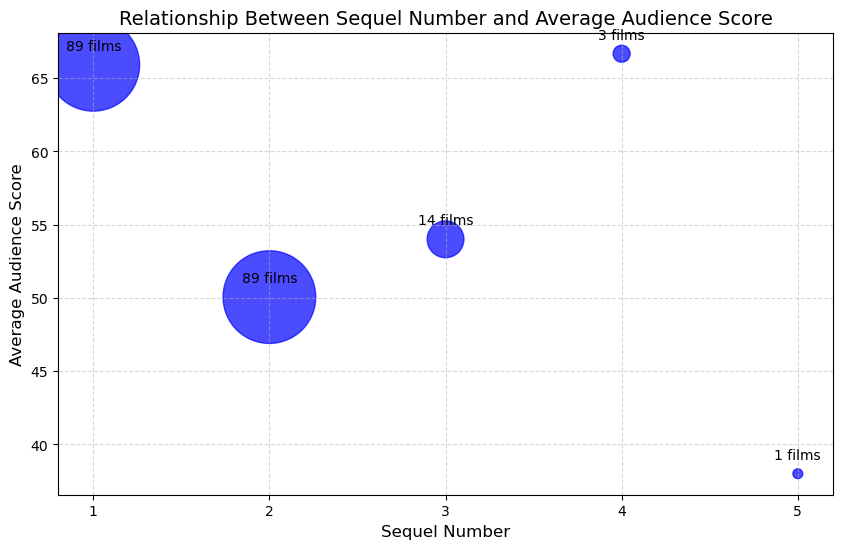

In [556]:
plot_sequel_ratings(final_df)

## Data handling

In this section, we will now show that our various approaches are feasible, by providing a small Proof of Concept for each type of approach. The results here are by no means our final results (of our final data story), but rather a intermediate viability checkpoint.

## I- Popularity analysis

##

## II. Quality analysis

In order to access useful indicators of popularity and perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset. The useful indicators we want to study here are : the box-office, the expert critic reviews, the expert critic score, the movie rewards. In comparison with the popularity analysis, the reviews and scores used are the ones given by experts.
We start by selecting the useful data in each dataset and we merge appropriate datasets to asses the feasability of exploitation. The size and content of the merges enbale us to discuss the possibility to assess the next operations, for example statistical analysis.


## III. Per-genre analysis 

As this section neither requires any additional datasets, nor does it use any different type of techniques, we do no provide a sample Proof of Concept for it. The final analysis will be ready for P3! 

## IV. Cultural differences